In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, os
import netCDF4
from functions import *

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow import keras


In [83]:
def csvs_to_dfs(path):
    dataframes = []
    for i in np.arange(49.0, 51.25, 0.25):
        row = []
        for j in np.arange(19.0, 21.25, 0.25):
            filename = path+'/data_[{},{}].csv'.format(i,j)
            row.append(pd.read_csv(filename))
        dataframes.append(row)
    return dataframes


datasets = csvs_to_dfs('../data/data_spacial')

In [10]:
datasets[0][0]

,t2m,d2m,msl,tp,ssrd,Date Time,windspeed_10,windspeed_100
0,264.171539,261.894817,102803.617703,3.858215e-05,0.0,2002-01-01 00:00:00,2.599300,5.580487
1,263.887147,261.538247,102922.759504,3.858215e-05,0.0,2002-01-01 01:00:00,2.772132,5.675756
2,262.562336,260.188147,103018.594495,3.478026e-05,0.0,2002-01-01 02:00:00,3.051740,5.769401
3,262.402476,259.990227,103045.812937,4.153918e-05,0.0,2002-01-01 03:00:00,2.531217,5.001142
4,262.478432,260.203070,103082.973444,4.153918e-05,0.0,2002-01-01 04:00:00,2.026651,4.314161
...,...,...,...,...,...,...,...,...
8755,265.111271,259.873988,101651.153035,1.408108e-06,0.0,2002-12-31 19:00:00,3.910917,6.271633
8756,264.012562,258.278059,101733.297313,4.224323e-07,0.0,2002-12-31 20:00:00,3.731204,6.034348
8757,263.640732,257.800537,101794.824029,0.000000e+00,0.0,2002-12-31 21:00:00,3.484256,5.852821
8758,263.018071,256.640504,101824.813211,0.000000e+00,0.0,2002-12-31 22:00:00,3.265416,5.326991


In [22]:
temperatures = np.zeros(shape=(len(datasets[0][0]), len(datasets), len(datasets[0])))
pressures = np.zeros(shape=(len(datasets[0][0]), len(datasets), len(datasets[0])))
for i, row in enumerate(datasets):
    for j, element in enumerate(row):
        for index in range(len(datasets[0][0])):
            temperatures[index,i,j] = element['t2m'][index]
            pressures[index,i,j] = element['msl'][index]      

In [39]:
temp_grads_x = np.gradient(temperatures, axis=1)

In [42]:
temp_grad = []
for i in range(temperatures.shape[0]):
    gradx = np.gradient(temperatures[i])[0][4,4]
    grady = np.gradient(temperatures[i])[1][4,4]
    grad = np.sqrt(gradx**2+grady**2)
    temp_grad.append(grad)

In [44]:
pres_grad = []
for i in range(pressures.shape[0]):
    gradx = np.gradient(pressures[i])[0][4,4]
    grady = np.gradient(pressures[i])[1][4,4]
    grad = np.sqrt(gradx**2+grady**2)
    pres_grad.append(grad)

In [85]:
df = datasets[4][4]

In [86]:
df['temp_grad'] = temp_grad
df['press_grad'] = pres_grad

In [88]:
df.to_csv('data_with_gradients.csv')

In [97]:
def datetimeToSignal(df):
    date_time = pd.to_datetime(df.pop('Date Time'), infer_datetime_format=True)

    def datetime_to_seconds(dates):
        return (float)((dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))

    timestamp_s = date_time.map(datetime_to_seconds)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    return df

def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_end-1, 5]) # 5 indicates 'windspeed10' parameter
        # move along one time step
        in_start += 1
    return array(X), array(y).reshape((len(y),1))

def data_prep(df, n_hours):

    train = df[df['Date Time']>='1994-01-01']
    train = train[train['Date Time']<'2002-01-01']
    test = df[df['Date Time']>='2002-01-01']
    test = test[test['Date Time']<'2003-01-01']

    # train = df.iloc[:int(0.8*len(df))]
    # test = df.iloc[int(0.8*len(df)):]

    train = datetimeToSignal(train)
    test = datetimeToSignal(test)

    values_train = train.values
    values_test = test.values

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(values_train)
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_y.fit(values_train[:,5].reshape(len(values_train),1))

    values_train = scaler.transform(values_train)
    values_test = scaler.transform(values_test)

    X_train, y_train = to_supervised(values_train, n_input=24, n_out=n_hours)
    X_test, y_test = to_supervised(values_test, n_input=24, n_out=n_hours)

    return X_train, y_train, X_test, y_test, scaler_y

def compile_and_fit(model, X_train, y_train):
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                                                   patience=2,
                                                   mode='min')

    model.compile(loss='mean_squared_error',
                  optimizer='adam')

    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping])

def evaluate(model, X_test, y_test, scaler_y, display = True, save_to = ''):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)

    # calculate RMSE
    testScore = sqrt(mean_squared_error(testYTrue, testPredictions))
    
    if display:
        print('Test Score: %.4f RMSE' % (testScore))
        length = 168
        start = random.randrange(len(testYTrue)-length)
        end = start+length
        plt.figure(figsize=[10,5])
        plt.xlabel('TimePoint in hours')
        plt.ylabel('$Mean sea level pressure[Pa]$')
        plt.grid()
        plt.plot(range(length), testYTrue[start:end],'k.')
        plt.plot(range(length),testPredictions[start:end],'r')
        plt.legend(['Actual','Predicted'])
        # plt.savefig(save_to)

    return testScore, testPredictions, testYTrue

def cross_corr(model, X_test, y_test, scaler_y):
    # make predictions
    testPredictions = model.predict(X_test)

    # invert scalling
    testPredictions = scaler_y.inverse_transform(testPredictions)
    testYTrue = scaler_y.inverse_transform(y_test)
    testPredictions = testPredictions.reshape((testPredictions.shape[0]))
    testYTrue = testYTrue.reshape((testYTrue.shape[0]))

    plt.figure(figsize=[10,5])
    plt.xcorr(testYTrue, testPredictions, usevlines=False)
    plt.grid()
    plt.title("Cross correlation between predictions and actual values")

In [74]:
dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,13)),
    Dropout(0.2),
    Dense(units=24, activation='relu'),
    Dropout(0.2),
    Dense(units=24, activation='relu'),
    Dropout(0.2),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])

In [71]:
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, n_hours=6)

C:\Users\48782\AppData\Local\Temp/ipykernel_13024/2921543069.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
C:\Users\48782\AppData\Local\Temp/ipykernel_13024/2921543069.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
C:\Users\48782\AppData\Local\Temp/ipykernel_13024/2921543069.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [72]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6978, 24, 13)
(6978, 1)
(1722, 24, 13)
(1722, 1)


In [75]:
compile_and_fit(dense, X_train, y_train)

Epoch 1/20
219/219 [==============================] - 5s 10ms/step - loss: 0.0294
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0160
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0136
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0129A: 0s - loss: 
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0117
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0111
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0104
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0101
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0096
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0092
Epoch 11/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0088
Epoch 12/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0085
Epoch

Test Score: 1.3575 RMSE


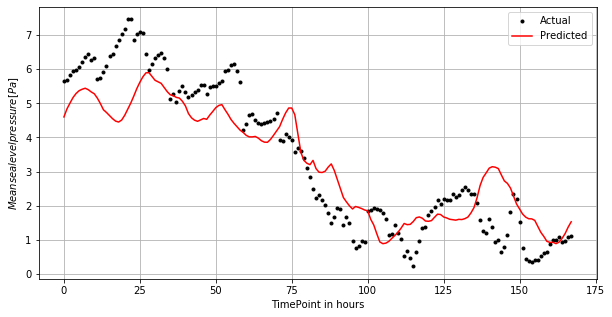

In [77]:
testScore, testPredictions, testYTrue = evaluate(dense, X_test, y_test, scaler_y, display = True)

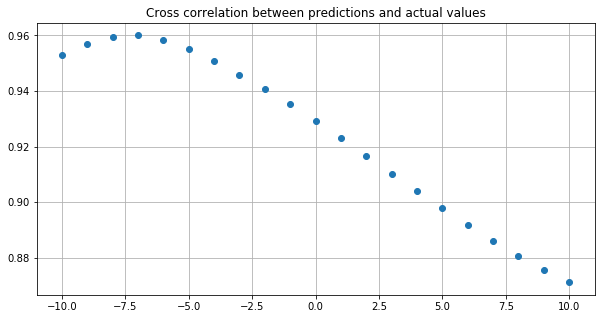

In [78]:
cross_corr(dense, X_test, y_test, scaler_y)

C:\Users\48782\AppData\Local\Temp/ipykernel_13024/4059782200.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
C:\Users\48782\AppData\Local\Temp/ipykernel_13024/4059782200.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
C:\Users\48782\AppData\Local\Temp/ipykernel_13024/4059782200.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Epoch 1/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0260
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0122
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0102
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0093
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0084
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0080
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0077
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0076
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0073
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0071
Epoch 11/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0069
Epoch 12/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0068
Epoch 13/20
219/219 [===

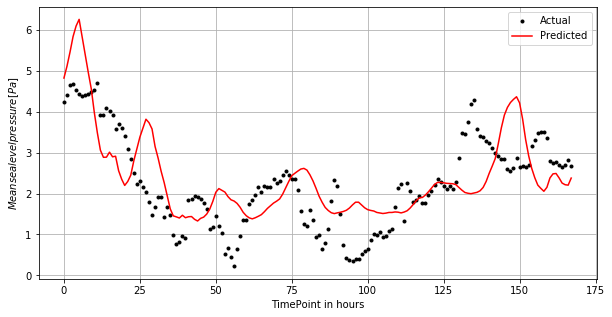

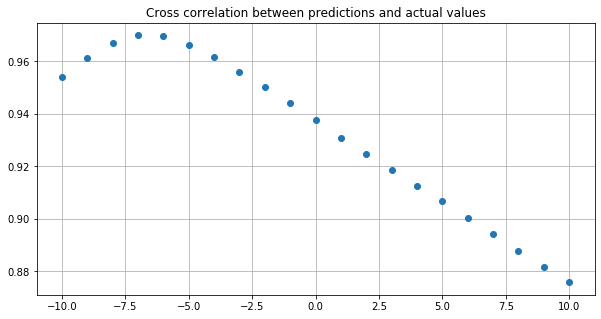

In [84]:
df = datasets[4][4]
dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,11)),
    Dropout(0.2),
    Dense(units=24, activation='relu'),
    Dropout(0.2),
    Dense(units=24, activation='relu'),
    Dropout(0.2),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, n_hours=6)
compile_and_fit(dense, X_train, y_train)
testScore, testPredictions, testYTrue = evaluate(dense, X_test, y_test, scaler_y, display = True)
cross_corr(dense, X_test, y_test, scaler_y)

## Gradienty czasowe

In [89]:
df = pd.read_csv('../data/data_single_loc.csv')

In [91]:
temperature = df['t2m']
pressure = df['msl']

In [94]:
temp_grad_t = np.gradient(temperature)
press_grad_t = np.gradient(pressure)

In [95]:
df['temp_grad_t'] = temp_grad_t
df['press_grad_t'] = press_grad_t

Epoch 1/20
2191/2191 [==============================] - 38s 17ms/step - loss: 0.0139
Epoch 2/20
2191/2191 [==============================] - 32s 15ms/step - loss: 0.0087
Epoch 3/20
2191/2191 [==============================] - 29s 13ms/step - loss: 0.0077
Epoch 4/20
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0073
Epoch 5/20
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0071
Epoch 6/20
2191/2191 [==============================] - 29s 13ms/step - loss: 0.0070
Epoch 7/20
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0069
Epoch 8/20
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0068
Epoch 9/20
2191/2191 [==============================] - 28s 13ms/step - loss: 0.0068
Epoch 10/20
2191/2191 [==============================] - 29s 13ms/step - loss: 0.0068
Epoch 11/20
2191/2191 [==============================] - 25s 12ms/step - loss: 0.0067
Epoch 12/20
2191/2191 [==============================] - 23s 10

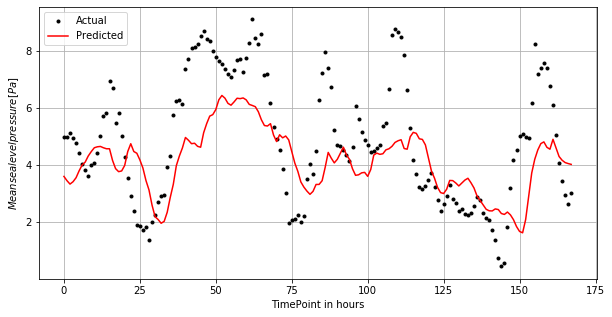

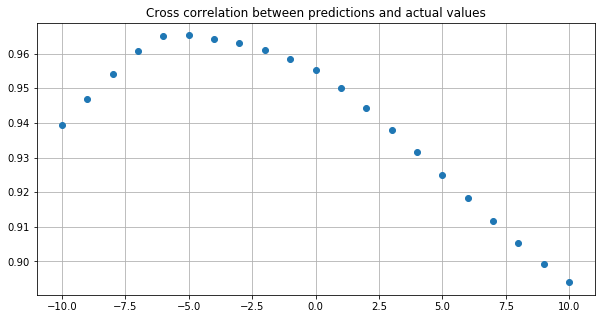

In [98]:
dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,13)),
    Dropout(0.2),
    Dense(units=24, activation='relu'),
    Dropout(0.2),
    Dense(units=24, activation='relu'),
    Dropout(0.2),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, n_hours=6)
compile_and_fit(dense, X_train, y_train)
testScore, testPredictions, testYTrue = evaluate(dense, X_test, y_test, scaler_y, display = True)
cross_corr(dense, X_test, y_test, scaler_y)

In [99]:
dense.save('../workdir/saved_models/wind_dense_with_time_grads.h5')

Epoch 1/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0170
Epoch 2/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0096
Epoch 3/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0081
Epoch 4/20
2191/2191 [==============================] - 24s 11ms/step - loss: 0.0077
Epoch 5/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0075
Epoch 6/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0074
Epoch 7/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0074
Epoch 8/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0073
Epoch 9/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0073
Epoch 10/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0073
Epoch 11/20
2191/2191 [==============================] - 23s 11ms/step - loss: 0.0072
Epoch 12/20
2191/2191 [==============================] - 23s 11

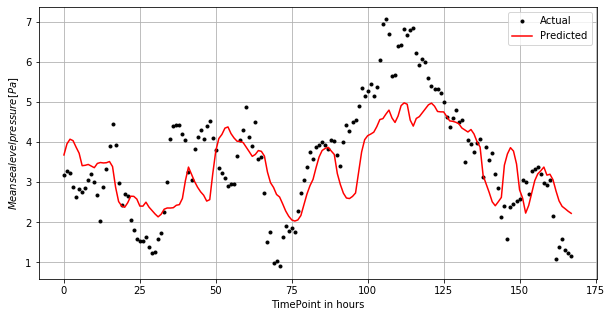

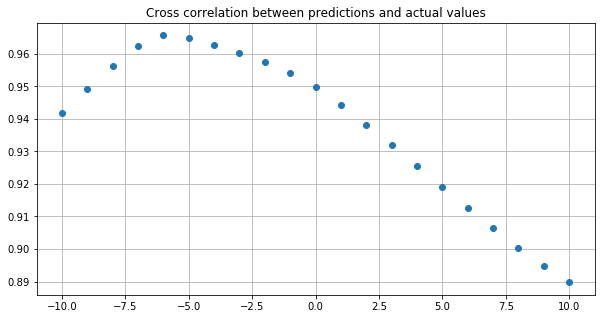

In [101]:
df = pd.read_csv('../data/data_single_loc.csv')
dense = Sequential([
    Dense(units=24, activation='relu', input_shape=(24,11)),
    Dropout(0.2),
    Dense(units=24, activation='relu'),
    Dropout(0.2),
    Dense(units=24, activation='relu'),
    Dropout(0.2),
    Dense(1),
    Reshape([1,24]),
    Dense(1),
    Reshape([1])
])
X_train, y_train, X_test, y_test, scaler_y = data_prep(df, n_hours=6)
compile_and_fit(dense, X_train, y_train)
testScore, testPredictions, testYTrue = evaluate(dense, X_test, y_test, scaler_y, display = True)
cross_corr(dense, X_test, y_test, scaler_y)